In [2]:
import os
import time
import json
%reload_ext e2emlstorlets.tools.ipython

In [3]:
os.environ['OS_AUTH_VERSION'] = '3'
os.environ['OS_AUTH_URL'] = 'http://127.0.0.1:5000/v3'
os.environ['OS_USERNAME'] = 'tester'
os.environ['OS_PASSWORD'] = 'testing'
os.environ['OS_USER_DOMAIN_NAME'] = 'default'
os.environ['OS_PROJECT_DOMAIN_NAME'] = 'default'
os.environ['OS_PROJECT_NAME'] = 'test'

In [40]:
%%storletapp extract_face.ExtractFace
import cv2
import numpy as np

def detect(im):
    mat=cv2.imdecode(im, cv2.IMREAD_GRAYSCALE)
    cascade = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    rects = cascade.detectMultiScale(mat)

    if len(rects) == 0:
        return [], mat
    rects[:, 2:] += rects[:, :2]
    rect = rects[0]
    return mat, rect

def crop(img, rect):
    h = rect[3]-rect[1]
    w = rect[2]-rect[0]
    x = rect[0]
    y = rect[1]
    return img[y:y+h, x:x+w]

class ExtractFace(object):
    def __init__(self, logger):
        self.logger = logger

    def __call__(self, in_files, out_files, params):
        metadata = in_files[0].get_metadata()
        out_files[0].set_metadata(metadata)

        # Read the image
        img_str = ''
        while True:
            buf = in_files[0].read(1024)
            if not buf:
                break
            img_str += buf
        img_nparr = np.fromstring(img_str, np.uint8)
        
        # Detect face
        mat, rect = detect(img_nparr)

        # Crop the face and decrease resolution
        face = crop(mat, rect)
        small_face = cv2.resize(face, (30,30))
        
        # Write result
        retval, small_face_buf = cv2.imencode('.jpg', small_face)
        out_files[0].write(small_face_buf)
        
        in_files[0].close()
        out_files[0].close()
        self.logger.debug('Done\n')

Upload storlets succeeded /storlet/extract_face.py
Example command `swift download <container> <object> -H X-Run-Storlet:extract_face.py`


In [41]:
# Iterate over all pictures, and extract faces
start_time = time.time()
%list_container -i tr -o obj_list
for obj in obj_list:
    input_path=os.path.join('/tr',obj)
    output_path=os.path.join('/str',obj)
    %copy \
        --storlet extract_face.py \
        --input path:$input_path \
        --output path:$output_path \
        -o result
extract_faces_time = time.time() - start_time
print('Done extracting faces in %d seconds' % round(extract_faces_time))

Done extracting faces in 19 seconds


In [ ]:
# Show before and after
%show_image --input path:/tr/bibi1.jpeg
%show_image --input path:/str/bibi1.jpeg

In [ ]:
# Train the model with all faces and name to id dictionary
start_time = time.time()
name_to_id = {'bibi': 1, 'merkel': 2, 'obama': 3, 'trump': 4}
params = {'name_to_id': json.dumps(name_to_id)}
input_path = os.path.join('path:str/', obj_list[0])
output_path = 'path:/trained/model'
extra = ','.join([ '/str/%s' % obj_name for obj_name in obj_list[1:]])
%copy \
    --storlet train_model.py \
    --input $input_path \
    --output $output_path \
    --extra $extra \
    -i params -o result
train_model_time = time.time() - start_time
print('Model training done in %d seconds' % round(train_model_time))

In [4]:
%play_video -c video -v eran_mov.avi

In [28]:
# Swap the face
start_time = time.time()
input_path = 'path:/video/eran_mov.avi'
output_path = 'path:/video/eran_swapped_mov.avi'
extra_resources = '/te/merkel_test2.jpeg'
%copy \
    --storlet video_swap_face.py \
    --input $input_path \
    --output $output_path \
    --extra $extra_resources \
    -o result
swap_faces_time = time.time() - start_time
print('Swapping faces done in %d seconds' % round(swap_faces_time))

Swapping faces done in 98 seconds


In [5]:
%play_video -c video -v eran_swapped_mov.avi

In [30]:
# Add face recognition tag
start_time = time.time()
input_path = 'path:/video/eran_swapped_mov.avi'
output_path = 'path:/video/tagged_mov.avi'
extra_resources = '/trained/model'
%copy \
    --storlet video_recognize_face.py \
    --input $input_path \
    --output $output_path \
    --extra $extra_resources \
    -o result
recognize_faces_time = time.time() - start_time
print('Recognize face done in %d seconds' % round(recognize_faces_time))

Recognize face done in 39 seconds


In [6]:
%play_video -c video -v tagged_mov.avi

In [33]:
# now lets see how this performs when working against S3
from e2emlstorlets.s3 import extract_faces, \
    train_model, swap_faces, recognize_faces
start_time = time.time()
extract_faces.extract_and_upload_all()
extract_faces_s3_time = time.time() - start_time
print('Done extracting faces in %d seconds' % round(extract_faces_s3_time))
start_time = time.time()
train_model.train_and_upload_model()
train_model_s3_time = time.time() - start_time
print('Model training done in %d seconds' % round(train_model_s3_time))
start_time = time.time()
swap_faces.get_swap_and_upload('merkel_test2.jpeg')
swap_faces_s3_time = time.time() - start_time
print('Swapping faces done in %d seconds' % round(swap_faces_s3_time))
start_time = time.time()
recognize_faces.get_tag_and_upload()
tag_faces_s3_time = time.time() - start_time
print('Recognizing faces done in %d seconds' % round(tag_faces_s3_time))

Processing bibi1.jpeg
Uploading small_bibi1.jpeg
Processing bibi10.jpeg
Uploading small_bibi10.jpeg
Processing bibi11.jpeg
Uploading small_bibi11.jpeg
Processing bibi12.jpeg
Uploading small_bibi12.jpeg
Processing bibi13.jpeg
Uploading small_bibi13.jpeg
Processing bibi14.jpeg
Uploading small_bibi14.jpeg
Processing bibi15.jpeg
Uploading small_bibi15.jpeg
Processing bibi16.jpeg
Uploading small_bibi16.jpeg
Processing bibi17.jpeg
Uploading small_bibi17.jpeg
Processing bibi18.jpeg
Uploading small_bibi18.jpeg
Processing bibi19.jpeg
Uploading small_bibi19.jpeg
Processing bibi2.jpeg
Uploading small_bibi2.jpeg
Processing bibi20.jpeg
Uploading small_bibi20.jpeg
Processing bibi3.jpeg
Uploading small_bibi3.jpeg
Processing bibi4.jpeg
Uploading small_bibi4.jpeg
Processing bibi5.jpeg
Uploading small_bibi5.jpeg
Processing bibi6.jpeg
Uploading small_bibi6.jpeg
Processing bibi7.jpeg
Uploading small_bibi7.jpeg
Processing bibi8.jpeg
Uploading small_bibi8.jpeg
Processing bibi9.jpeg
Uploading small_bibi9.jpe

/usr/local/lib/python2.7/dist-packages/e2emlstorlets/video_swap_face/video_swap_face.py:141: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  hull1.append(points1[hullIndex[i]])
/usr/local/lib/python2.7/dist-packages/e2emlstorlets/video_swap_face/video_swap_face.py:142: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  hull2.append(points2[hullIndex[i]])


No more frames. Exiting

Uploading Result
Swapping faces done in 105 seconds
Swapped movie download Done.
Model download Done.
Tagging face
No more frames. Exiting

Uploading Result
Recognizing faces done in 49 seconds


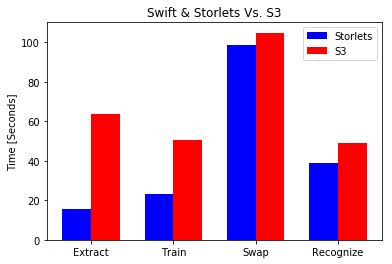

In [34]:
from e2emlstorlets.tools import plot_times
plot_times.show_plot(extract_faces_time,
                     train_model_time,
                     swap_faces_time,
                     recognize_faces_time,
                     extract_faces_s3_time,
                     train_model_s3_time,
                     swap_faces_s3_time,
                     tag_faces_s3_time)